## Generative models

[Generative Adversarial Nets](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

I read an article about generative models from [Open AI](https://openai.com/blog/generative-models/). These are my notes about what I understand about them, and some basic implementation of a generative model for images.

I like how the article mentions a quote from Richard Feynman.

> What I cannot create, I do not understand.

It seems like there is subtle relationship between compression techniques and generative models. When we train neural networks on images, we try to obtain a latent representation of the image in a lower dimensional space. This is essentially what a compression algorithm does. The idea behind generative models is to use this low dimensional representation as a pivot to generate or sample new images from the entire distribution of images. This a tough problem. If we are to consider the whole number of possible images that we can generate using some fixed resolution, it grows with an exponential rate. And, trying to get to that space of probabilities is nothing less than amazing. I am very impressed with some of the results that were shown in the web, why does it work? Let's take a deeper look at what these generative models especially adversarial neural networks.

This gets even better, these models are unsupervised. Intuitively this has improved classification performance of deep neural networks even if the network has access to limited set of labels. This could be one of the things that will change the way we look at supervised learning. You don't need to show a million images to a kid to teach how a cat looks like. Given a set of properly labelled data, you should be able to achieve a decent classification performance.

### [Generative Adversarial Nets Paper](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

The paper explains how a generative network (trying to capture training data distribution) and a discriminator network (estimates the probability that a sample came from training data) coupled together to form an efficient network called generative adversarial network. One can think of discriminator as a trainable cost function, which is a huge boost from maximum likelyhood estimation or some other methods (like NCE and Monte Carlo sampling, which I haven't read). The paper points out some of the inefficiencies of current techniques and gives an interesting example of generating fake currency (generator network), police (tries to discriminate between fake and original currency). As they start this game, the idea is that the generator learns to produce more and more accurate looking images from the distribution. When the discriminator is unable to diffrentiate between the original data distribution and generative distribution, the model would have reached its equilibrium so D(x) = 1/2 (think of tossing a coin, completely random). The paper also points some theory behind the convergence of model.

The cost function is a minmax game which does two things at once. 

1. Minimize the difference between data distribution and and data generation distribution

2. Maximize the probability that output comes from data

Let's implement a basic generative neural network in Tensorflow and Python. [Toy model as explained here](http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html)

In [2]:
from IPython.display import Image

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

We will try to generate samples from a normal distribution. This is what the paper mentions as P(data). Both the generator and discriminator does not have access to this function, yet they have to get a basis function which could sample from this data.

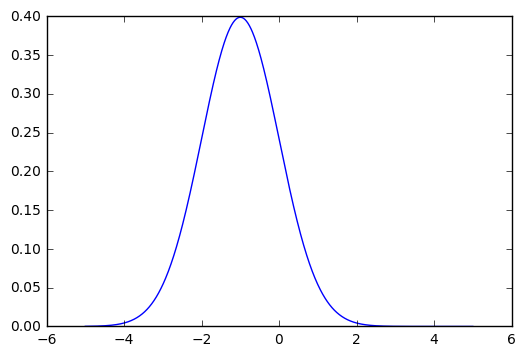

In [4]:
mu,sigma=-1,1
xs=np.linspace(-5,5,1000)
plt.plot(xs, norm.pdf(xs,loc=mu,scale=sigma))

We will be using a multi-layer perceptron both for the generator and discriminator.

In [5]:
def mlp(input,output_dim):
    # create a tensorflow network
    w1 = tf.get_variable('w0',[input.get_shape()[1],6], initializer= tf.random_normal_initializer())
    b1 = tf.get_variable('b0',[6], initializer= tf.constant_initializer(0.0))
    w2 = tf.get_variable('w1',[6,5], initializer= tf.random_normal_initializer())
    b2 = tf.get_variable('b1',[5], initializer= tf.constant_initializer(0.0))
    w3 = tf.get_variable('w2',[5,output_dim], initializer= tf.random_normal_initializer())
    b3= tf.get_variable('b2',[output_dim], initializer= tf.constant_initializer(0.0))
    # the activation functions
    fc1 = tf.nn.tanh(tf.matmul(input,w1)+b1)
    fc2 = tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    fc3 = tf.nn.tanh(tf.matmul(fc2,w3)+b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

We will now define a momentum optimizer that we can use to optimize each network.

In [6]:
def momentum_optimizer(loss, var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.001, batch, 10000//4, 0.95)
    optimizer = tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,global_step= batch,var_list = var_list)
    return optimizer

One of the things that can improve the performance of network is to pre-train the discriminator network, this will speed up the convergence rate.

In [7]:
# Minibatch size
M = 200

### Pre-training the Discriminator

A binary classification network is trained by using some random samples, and some samples from the data. 

In [8]:
with tf.variable_scope('D_pre'):
    input_node = tf.placeholder(tf.float32, shape= (M,1))
    train_labels = tf.placeholder(tf.float32, shape= (M,1))
    # binary classifier
    D, theta = mlp(input_node,1)
    loss = tf.reduce_mean(tf.square(D- train_labels))

In [9]:
optimizer = momentum_optimizer(loss, None)

In [10]:
sess=tf.InteractiveSession()
tf.initialize_all_variables().run()

In [11]:
def plot_d0(D,input_node):
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')
    # decision boundary
    r=1000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in a minibatch
    for i in range(r//M):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D,{input_node: x})

    ax.plot(xs, ds, label='decision boundary')
    ax.set_ylim(0,1.1)
    plt.legend()

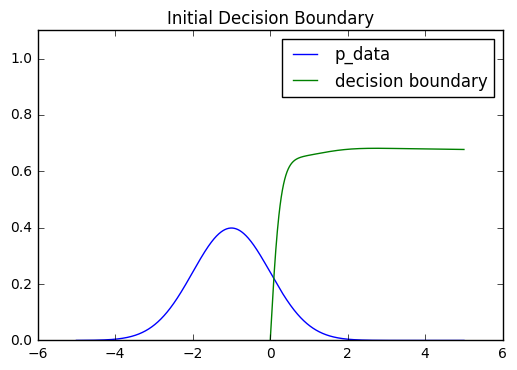

In [12]:
plot_d0(D,input_node)
plt.title('Initial Decision Boundary')

In [13]:
lh=np.zeros(1000)
for i in range(1000):
    d=(np.random.random(M)-0.5) * 10.0
    # instead of sampling only from gaussian, want the domain to be covered as uniformly as possible
    labels=norm.pdf(d,loc=mu,scale=sigma)
    lh[i],_=sess.run([loss,optimizer], {input_node: np.reshape(d,(M,1)), train_labels: np.reshape(labels,(M,1))})

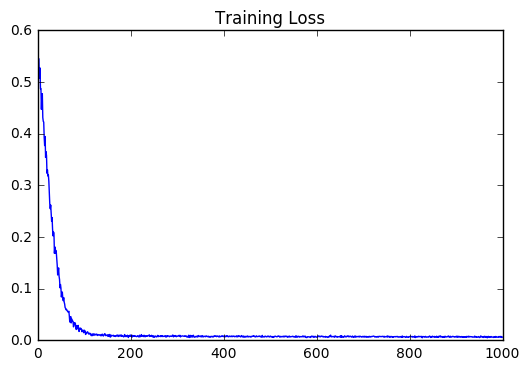

In [14]:
plt.plot(lh)
plt.title('Training Loss')

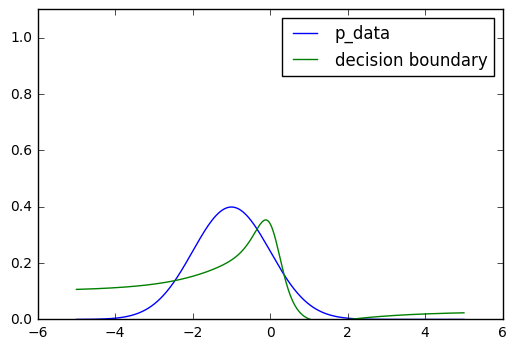

In [15]:
plot_d0(D,input_node)

In [16]:
weightsD=sess.run(theta)

In [17]:
sess.close()

### Building the network

In [18]:
# Generator
with tf.variable_scope('G'):
    z_node = tf.placeholder(tf.float32, shape=(M,1))
    G, theta_g = mlp(z_node, 1)
    G = tf.mul(5.0, G)

In [19]:
# Discriminator
with tf.variable_scope('D') as scope:
    x_node = tf.placeholder(tf.float32, shape=(M,1))
    fc, theta_d = mlp(x_node, 1)
    D1=tf.maximum(tf.minimum(fc,.99), 0.01)
    scope.reuse_variables()
    fc,theta_d=mlp(G,1)
    D2=tf.maximum(tf.minimum(fc,.99), 0.01)

In [20]:
# objectives
obj_d = tf.reduce_mean(tf.log(D1)+ tf.log(1-D2))
obj_g = tf.reduce_mean(tf.log(D2))

In [21]:
# optimizer for G and D
opt_d = momentum_optimizer(1-obj_d, theta_d)
opt_g = momentum_optimizer(1-obj_g, theta_g)

In [22]:
sess=tf.InteractiveSession()
tf.initialize_all_variables().run()

In [23]:
for i,v in enumerate(theta_d):
    sess.run(v.assign(weightsD[i]))

In [24]:
def plot_fig():
    # plots pg, pdata, decision boundary 
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')

    # decision boundary
    r=5000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(r//M):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D1,{x_node: x})

    ax.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs=np.linspace(-5,5,r)
    gs=np.zeros((r,1)) # generator function
    for i in range(r//M):
        z=np.reshape(zs[M*i:M*(i+1)],(M,1))
        gs[M*i:M*(i+1)]=sess.run(G,{z_node: z})
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-5,5,10), histc/float(r), label='p_g')

    # ylim, legend
    ax.set_ylim(0,1.1)
    plt.legend()

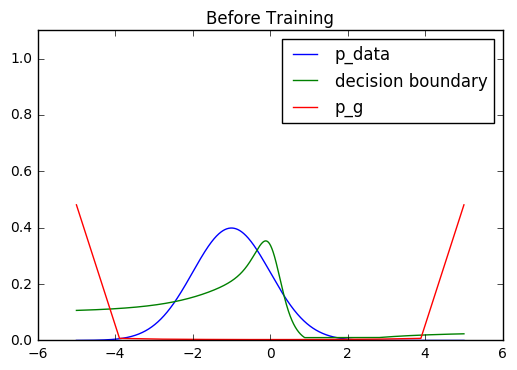

In [25]:
plot_fig()
plt.title('Before Training')

In [26]:
TRAIN_ITERS = 15000

In [27]:
k=1
histd, histg= np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
for i in range(TRAIN_ITERS):
    for j in range(k):
        x= np.random.normal(mu,sigma,M) # sampled m-batch from p_data
        x.sort()
        z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01  # sample m-batch from noise prior
        histd[i],_=sess.run([obj_d,opt_d], {x_node: np.reshape(x,(M,1)), z_node: np.reshape(z,(M,1))})
    z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01 # sample noise prior
    histg[i],_=sess.run([obj_g,opt_g], {z_node: np.reshape(z,(M,1))}) # update generator
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


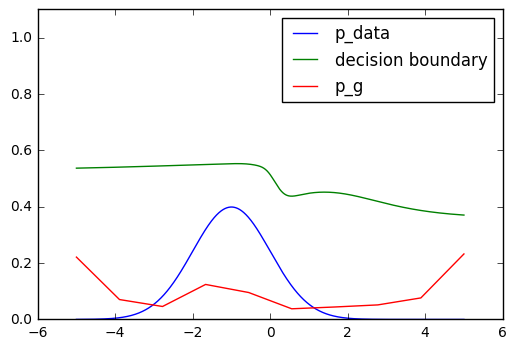

In [28]:
plot_fig()